## 1 Data Cleaning

Not all data cleaning and preparation codes are put in this section. There will still be some specific data processing procedures in the cells of the related sections, which is not included in this section.

In [1]:
import pandas as pd
import plotly.graph_objects as go
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime

directory = 'data/'

_Delete rows with 'Province_State'='Recovered' in csse_covid_19_daily_reports_us._

In [2]:
csse_covid_19_daily_reports_us = pd.read_csv(directory+'csse_covid_19_daily_reports_us.csv')
# print(csse_covid_19_daily_reports_us.shape)
csse_covid_19_daily_reports_us = csse_covid_19_daily_reports_us[csse_covid_19_daily_reports_us['Province_State']!='Recovered']
# print(csse_covid_19_daily_reports_us.shape)

_Calculate the delta deaths, confirmed, active, recovered of each record in csse_covid_19_daily_reports_us.csv_

In [3]:
def addDeltaIndicator(df,indicator_list):
    for indicator in indicator_list:
        delta_indicator_name = 'Delta_'+indicator
        tmp = df[indicator].to_list()
        tmp_delta = []
        for i in range(len(tmp)-1):
            tmp_delta.append(tmp[i+1]-tmp[i])
        tmp_delta.append(0)
        df[delta_indicator_name] = tmp_delta
    return df

csse_covid_19_daily_reports_us = pd.read_csv(directory+'csse_covid_19_daily_reports_us.csv')
csse_covid_19_daily_reports_cal = csse_covid_19_daily_reports_us[csse_covid_19_daily_reports_us['Province_State']=='California'].sort_values('Last_Update',ignore_index=True)
csse_covid_19_daily_reports_cal=csse_covid_19_daily_reports_cal.fillna(0)

indicator_list = ['Last_Update','Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate', 'People_Hospitalized', 'Case_Fatality_Ratio','Testing_Rate', 'Hospitalization_Rate', 'People_Tested','Mortality_Rate']
cal_partial = pd.DataFrame(csse_covid_19_daily_reports_cal[indicator_list])



delta_indicator_list = ['Confirmed', 'Deaths', 'Recovered', 'Active','People_Hospitalized','People_Tested']
cal_delta = addDeltaIndicator(cal_partial,delta_indicator_list)

csse_covid_19_daily_reports_NY = csse_covid_19_daily_reports_us[csse_covid_19_daily_reports_us['Province_State']=='New York'].sort_values('Last_Update',ignore_index=True)
csse_covid_19_daily_reports_NY=csse_covid_19_daily_reports_NY.fillna(0)#.interpolate()
NY_partial = pd.DataFrame(csse_covid_19_daily_reports_NY[indicator_list])
NY_delta = addDeltaIndicator(NY_partial,delta_indicator_list)
NY_delta.to_csv('ny_add_delta.csv')

_Delete the columns that we don't need. The external dataset 'state_abbreviations.txt' will be helpful in doing this work._

In [4]:
state_abbrev_txt = open(directory+'state_abbreviations.txt','r')
code_dict = eval(state_abbrev_txt.read())
state_list = list(code_dict.keys())
# import requests
# url = 'https://github.com/WilliamLiuAtCPC/Data200_GradProj_ext_dataset/blob/main/state_abbreviations.txt?raw=true'
# resp = requests.get(url)
# with open('Dataset A/file.txt', 'wb') as f:
#     f.write(resp.content)

# state_abbrev_txt = open(directory+'file.txt','r')
# code_dict = eval(state_abbrev_txt.read())
# state_list = list(code_dict.keys())

In [5]:
def addDeltaIndicatorAllStates(df,state_list,indicator_list):
    for i in range(len(state_list)):
        state = state_list[i]
        one_state_df = df[df['Province_State']==state].sort_values('Last_Update',ignore_index=True)
        # one_state_df['Last_Update'] = pd.to_datetime(one_state_df['Last_Update'])
        # one_state_df = one_state_df.fillna(0)
        one_state_df = addDeltaIndicator(one_state_df,indicator_list)
        one_state_df = add_past_n_days(one_state_df,'Delta_Confirmed',30)
        if i==0:
            all_state_df = pd.DataFrame(one_state_df)
        else:
            all_state_df = pd.concat([all_state_df,one_state_df],axis=0,ignore_index=True)
    return all_state_df

def filter_na_rows(df,indicator_list):
    for indicator in indicator_list:
        df = df[~df[indicator].isna()]
    return pd.DataFrame(df)

def select_columns(df,columns):
    return pd.DataFrame(df[columns])

def add_past_n_days(df,column_name,n):
    while n>0:
        new_c_name = column_name+'_'+str(n)
        tmp = []
        for j in range(n):
            tmp.append(0)
        for i in range(df.shape[0]-n):
            tmp.append(df[column_name].iloc[i])
        df[new_c_name] = tmp
        n-=1
    return df.iloc[10:]

all_state_reports_delta = addDeltaIndicatorAllStates(csse_covid_19_daily_reports_us,state_list,delta_indicator_list)
nonzero_indicators = ['Confirmed','Recovered','Deaths','Active','People_Tested','People_Hospitalized']
all_state_reports_delta = filter_na_rows(all_state_reports_delta,nonzero_indicators)
columns_we_want = ['Last_Update','Confirmed','Recovered','Deaths','Active','People_Tested',
                   'People_Hospitalized','Delta_Confirmed','Delta_Recovered','Delta_Deaths',
                   'Delta_People_Hospitalized','Delta_Active','Delta_People_Tested','Province_State',
                  ]#'Last_Update',
for i in range(30):
    columns_we_want.append('Delta_Confirmed_'+str(i+1))
all_state_reports_delta = select_columns(all_state_reports_delta,columns_we_want)

# 2 EDA
## 2.1 Are there any inequity in the treatment of COVID-19 between male and female in 2020?

### 2.1.1 Data Preparation

Only keep rows of year 2020 with 'Age Group'=='All Ages'.

In [6]:
cdc_death_counts_by_sex_age_state = pd.read_csv(directory+'cdc_death_counts_by_sex_age_state.csv')

In [7]:
def getDeathByYear(df,year):
    new_df = pd.DataFrame(df[(df['Group']=='By Year')&(df['Year']==year)])
    return new_df

def getDeathByAge(df,age_group):
    new_df = pd.DataFrame(df[df['Age Group']==age_group])
    return new_df
    

death_by_2020 = getDeathByYear(cdc_death_counts_by_sex_age_state,2020)
death_by_2020_allAges = getDeathByAge(death_by_2020,'All Ages')

invalid_state_list = ['New York City','Puerto Rico']
clean_death_by_2020_allAges = death_by_2020_allAges[~death_by_2020_allAges['State'].isin(invalid_state_list)]

Merge clean_death_by_2020_allAges with the external dataset 'population_by_sex_state_2020.csv'. Calculate female's, male's and overall COVID-19 death rate for each state.

In [8]:
def addCovidDeathRate(population_df,death_df):
    f_death_df = death_df[death_df['Sex']=='Female'][['State','COVID-19 Deaths']].rename(columns={"COVID-19 Deaths": "F_deaths"})
    m_death_df = death_df[death_df['Sex']=='Male'][['State','COVID-19 Deaths']].rename(columns={"COVID-19 Deaths": "M_deaths"})
    all_sex_death_df = death_df[death_df['Sex']=='All Sexes'][['State','COVID-19 Deaths']].rename(columns={"COVID-19 Deaths": "total_deaths"})
    
    new_df = population_df.merge(f_death_df,how='left',left_on='Location',right_on='State').drop(columns='State')
    new_df = new_df.merge(m_death_df,how='left',left_on='Location',right_on='State').drop(columns='State')
    new_df = new_df.merge(all_sex_death_df,how='left',left_on='Location',right_on='State').drop(columns='State')
    
    new_df['F_DR%'] = new_df['F_deaths']*100/new_df['Female']
    new_df['M_DR%'] = new_df['M_deaths']*100/new_df['Male']
    new_df['Total_Covid_DR%'] = new_df['total_deaths']*100/new_df['Total']
    return new_df

def addDRSexGap(df):
    df['DeathRateGap(M-F)%'] = df['M_DR%']-df['F_DR%']
    return df

def addGapMaleToFemale(df):
    df['GapRatioMToF%'] = df['DeathRateGap(M-F)%']/df['F_DR%']*100
    return df

population_by_sex_state_2020 = pd.read_csv(directory+'population_by_sex_state_2020.csv')
death_rate_by_sex_state_2020 = addCovidDeathRate(population_by_sex_state_2020,clean_death_by_2020_allAges)
death_rate_by_sex_state_2020 = addDRSexGap(death_rate_by_sex_state_2020)
death_rate_by_sex_state_2020 = addGapMaleToFemale(death_rate_by_sex_state_2020)
death_rate_by_sex_onlystate_2020 = death_rate_by_sex_state_2020[death_rate_by_sex_state_2020['Location']!='United States']
# death_rate_by_sex_onlystate_2020

In [9]:
def addStateCode(original_table,code_dic):
    original_table['Code'] = original_table.loc[:,'Location'].apply(code_dic.get)
    return original_table


death_rate_by_sex_onlystate_2020 = addStateCode(death_rate_by_sex_onlystate_2020,code_dict)
# death_rate_by_sex_onlystate_2020

/tmp/ipykernel_77/898076217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_table['Code'] = original_table.loc[:,'Location'].apply(code_dic.get)


### 2.1.2 Visualization and Analysis

Draw the USA map with color for each state using the overall COVID-19 death rate. And see if there was inequity between different states.

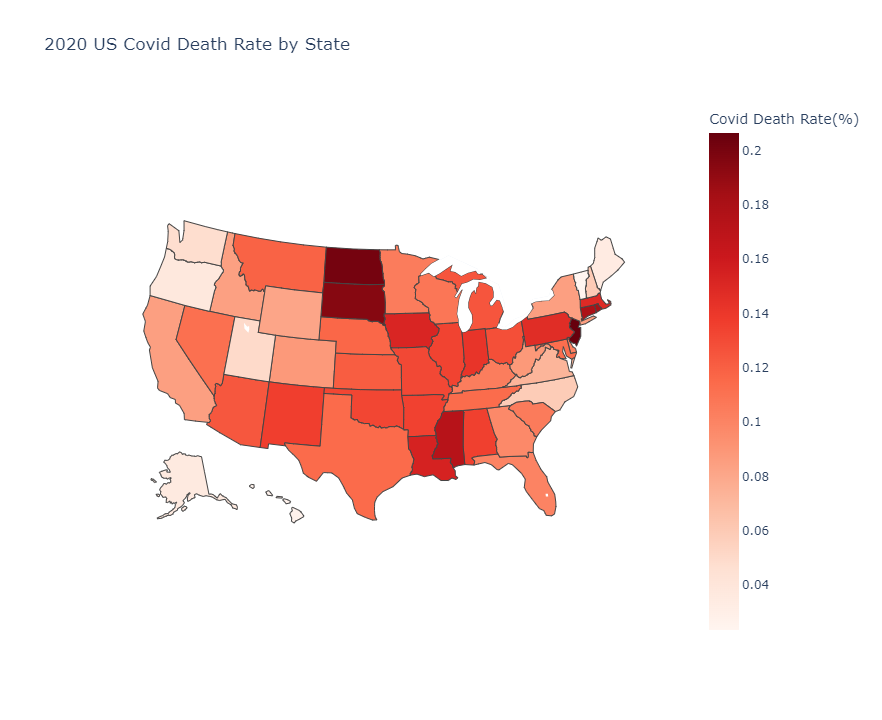

In [10]:
fig = go.Figure(data=go.Choropleth(
    locations=death_rate_by_sex_onlystate_2020['Code'], # Spatial coordinates
    z = death_rate_by_sex_onlystate_2020['Total_Covid_DR%'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Covid Death Rate(%)",
))
fig.update_layout(
    width=900,
    height=720,
    title_text = '2020 US Covid Death Rate by State',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

Draw the USA map with color for each state using the value of (male's death rate - female's death rate) in percent. And see if there was gender inequity.

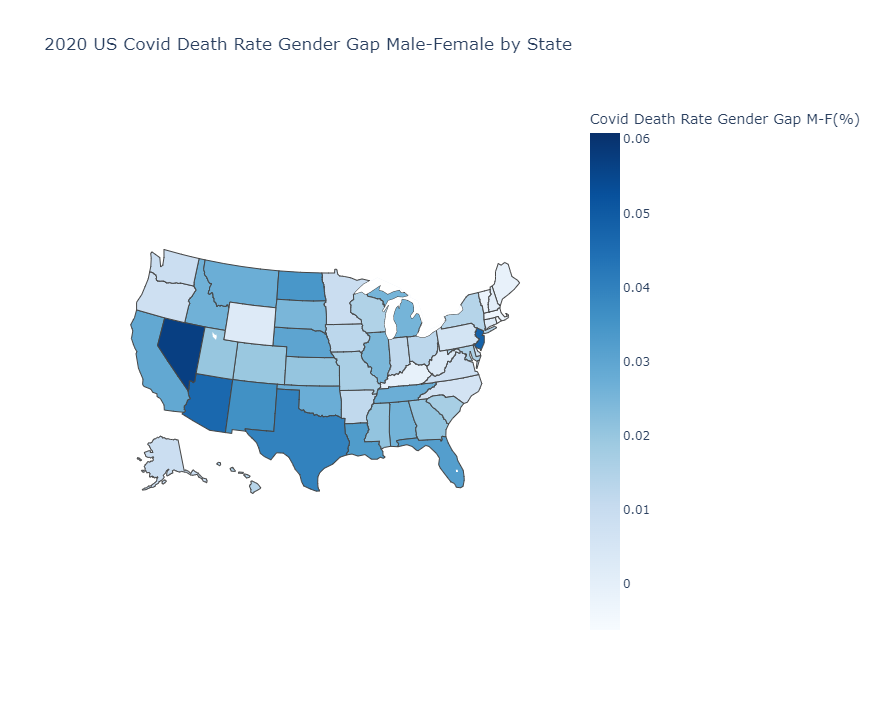

In [11]:
fig = go.Figure(data=go.Choropleth(
    locations=death_rate_by_sex_onlystate_2020['Code'], # Spatial coordinates
    z = death_rate_by_sex_onlystate_2020['DeathRateGap(M-F)%'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Covid Death Rate Gender Gap M-F(%)",
))
fig.update_layout(
    width=900,
    height=720,
    title_text = '2020 US Covid Death Rate Gender Gap Male-Female by State',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

Draw the USA map with color for each state using the value of how much higher is male's death rate is to female's death rate in percent. And see if there was gender inequity.

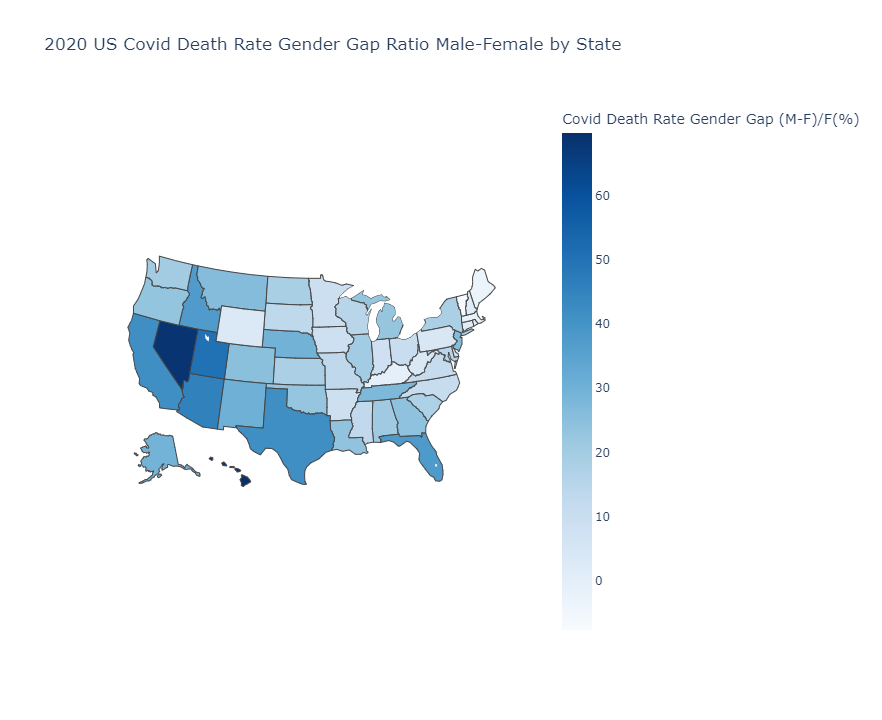

In [12]:
fig = go.Figure(data=go.Choropleth(
    locations=death_rate_by_sex_onlystate_2020['Code'], # Spatial coordinates
    z = death_rate_by_sex_onlystate_2020['GapRatioMToF%'], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Covid Death Rate Gender Gap (M-F)/F(%)",
))
fig.update_layout(
    width=900,
    height=720,
    title_text = '2020 US Covid Death Rate Gender Gap Ratio Male-Female by State',
    geo_scope='usa', # limite map scope to USA
)
fig.show()

_As we can see from the plot above, there is inequity between states and genders. People live in ND, NJ, SD suffered a higher risk of passing away because of Covid. Men had a higher covid-19 death rate than women nation wide in 2020. Especially in NV and HI, males had a nearly 60% higher death rate than females. There are also some state that females have a higher Covid death rate, like VT (7% higher)._

## 2.2 Explore the relationships between some indicators
### I. Analyse all states together
Use the daily report data to plot a corr heatmap between those indicators like the number of deaths, active, delta_confirmed......
Note: some data are missing in People_Hospitalized, Hospitalization_Rate, Recovered...So, I need to drop those NaN rows.

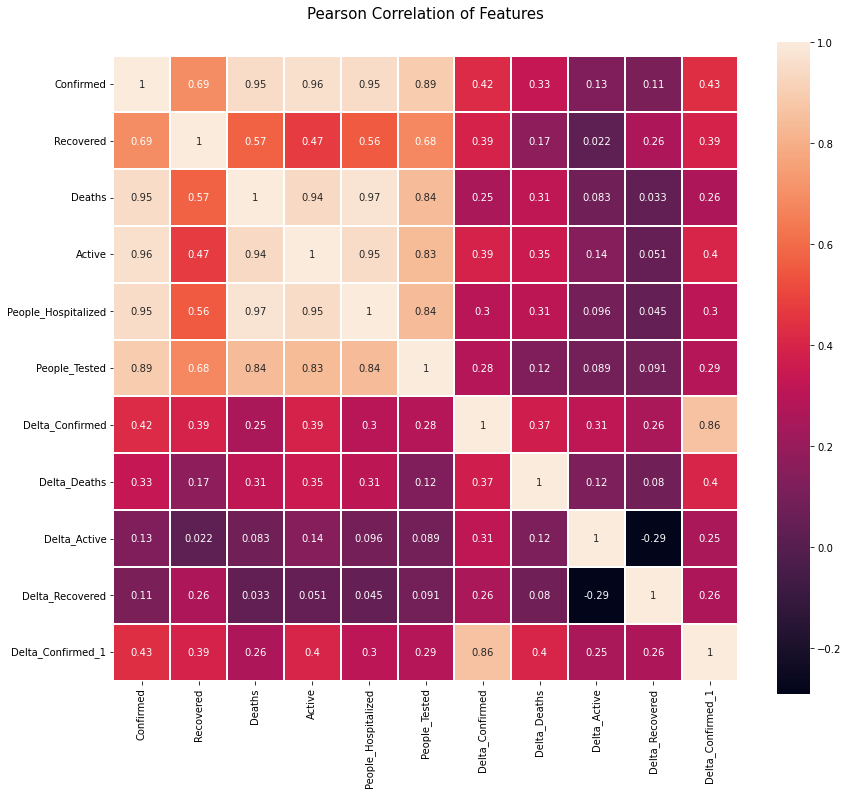

In [13]:
dataset = all_state_reports_delta.drop(['Province_State'],axis=1)
feature_list = ['Confirmed','Recovered','Deaths','Active','People_Hospitalized','People_Tested','Delta_Confirmed','Delta_Deaths','Delta_Active','Delta_Recovered','Delta_Confirmed_1']
dataset=  dataset[feature_list]
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(dataset.corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white',annot=True)
plt.show();

_As is shown in the heatmap, there is strong positive correlation between Confirmed, Recovered, Deaths, Active, People Tested, People Hospitalized and Delta_People_Tested._

### II. What about Only New York?
Use the daily report data of New York to plot a corr heatmap between those indicators like the number of deaths, active, delta_confirmed......

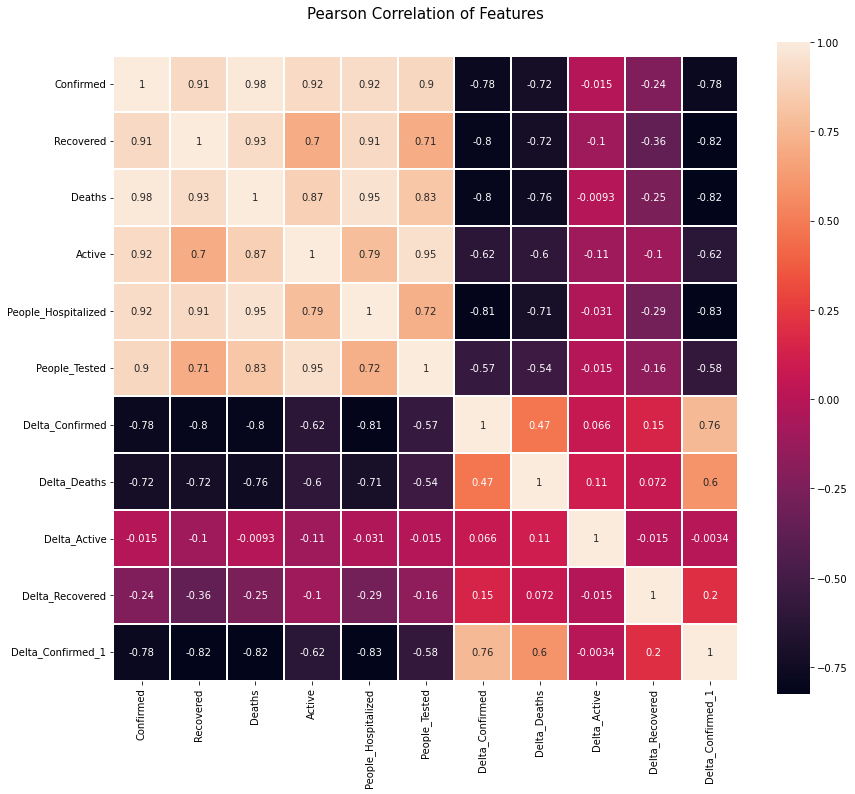

In [14]:
used_indicators = ['Confirmed','Recovered','Deaths','Active','People_Hospitalized','People_Tested','Hospitalization_Rate','Delta_Confirmed','Delta_Deaths','Delta_Active']
dataset = all_state_reports_delta[all_state_reports_delta['Province_State']=='New York'].drop(['Province_State'],axis=1)
feature_list = ['Confirmed','Recovered','Deaths','Active','People_Hospitalized','People_Tested','Delta_Confirmed','Delta_Deaths','Delta_Active','Delta_Recovered','Delta_Confirmed_1']
dataset=  dataset[feature_list]

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(dataset.corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white',annot=True)
plt.show();

_As is shown in the heatmap of NY, there is strong positive correlation between Confirmed, Recovered, Deaths, Active, People Tested, People Hospitalized and Delta_People_Tested. The number of People_Tested and People_Hospitalized are negatively correlated to almost all 'Delta' indicators, which means that Covid-19 tests and hospitalization can have some good effects on controlling the pandemic in NY._

### III. What about California?
Note that California's Recovered is N/A for all rows and most of the 'People_Hospitalized' are empty.

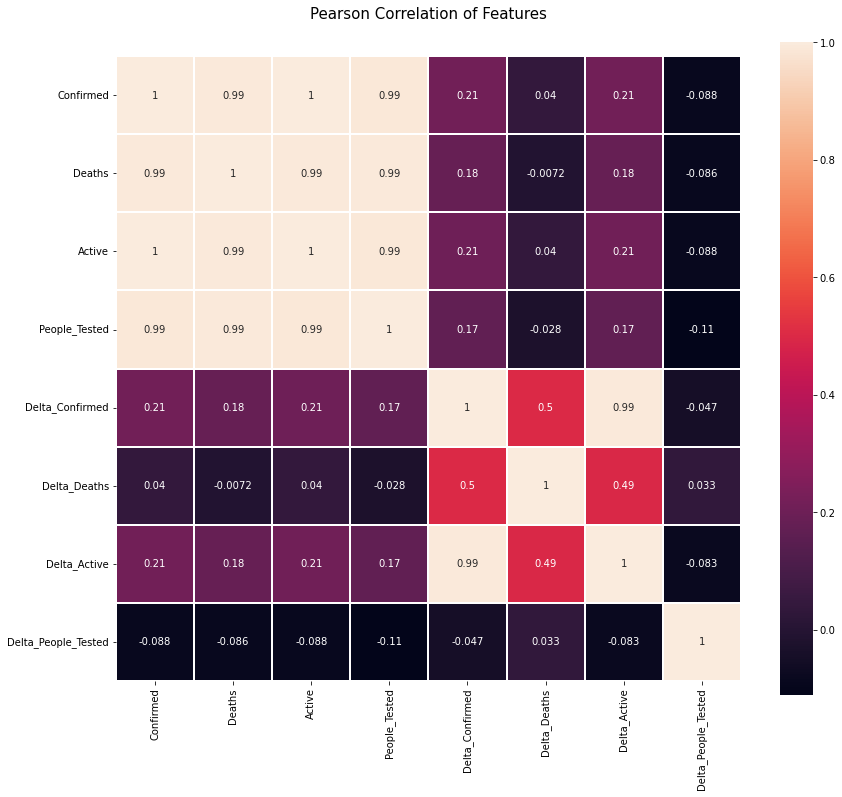

In [15]:
used_indicators = ['Confirmed','Deaths','Active','People_Tested','Delta_Confirmed','Delta_Deaths','Delta_Active','Delta_People_Tested']
dataset = cal_delta[used_indicators]
dataset = dataset[dataset['People_Tested']!=0]
# dataset = dataset[dataset['Recovered']!=0]
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(dataset.corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white',annot=True)
plt.show();

_As we can see from the heatmap of CA, there is still a strong correlation between People_Tested, Confirmed, Active and Deaths. Also, the number of People_Tested and People_Hospitalized are negatively correlated to almost all 'Delta' indicators, which means that Covid-19 tests and hospitalization can have some good effects on controlling the pandemic in CA. But this negative correlation is not so strong as that in New York._

### IV. Some Thoughts about the above 3 analysis


Compare the three plots above, we can see there is a clear common thing that Confirmed, Recovered, Deaths, Active, People Tested and People Hospitalized. But when we look at different states, things could be very different. Although we can use the data from all states to explore a universal pattern or rule, that rule or pattern may not be fit for a specific area.

# 3 Modeling

## 3.1 My Goal

My best friend is living in New York and I want to visit him during this winter break. So I want to train a model that can predict next day or next few days' number of confirmed cases in New York based on that day's indicator data and history data.

As I introduced the concept of ‘Delta_{indicator}’ in the previous section, I’ll still use the concept in this section but I only calculated the ‘Delta_Confirmed’ in this problem, in order to avoid using future indicators to predict another future indicator mistakenly. Then this problem can be reformed into the following question:

_"Can I use the current and history values of the indicators of a day to predict that day’s value for ‘Delta_Confirmed’._

That is to say, the future prediction problem becomes a regression problem that finds the relationship between ‘Delta_Confirmed’ and other indicators."


In [16]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def toLog(df,c_namelist):
    for c_name in c_namelist:
        df['log_'+c_name] = np.log(df[c_name])
    return df

def getPower(df,c_namelist,p):
    for c_name in c_namelist:
        df[c_name+'_2'] = df[c_name]**p
    return df

def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

def showRefLine(n=10000):
    y_x = [0,n]
    plt.plot(y_x,y_x,'r');

def predict_testset(model,dataset):    
    df = pd.DataFrame(dataset).reset_index()
    for i in range(len(dataset)):
        tmp_pred = model.predict(df)
        for j in range(len(dataset)-i-1):
            df.loc[i+j+1,'Delta_Confirmed_'+str(j+1)] = tmp_pred[i]
    prediction = model.predict(df)
    return prediction


## 3.2 Data Preparation

As the dataset is sorted by date and our problem is a actually a time series analysis problem. So I use the last 15% days in New York's records as the test set and use other data as training set.

In [17]:
dataset = all_state_reports_delta[all_state_reports_delta['Province_State']=='New York'].drop(['Province_State'],axis=1)
testset_size = int(len(dataset)*0.15)
original_train = dataset[:-(testset_size)+1]
test = dataset[-(testset_size)+1:]
train, val = train_test_split(original_train, test_size = 0.1, random_state = 17)

## 3.3 Feature Engineering
### 3.3.1 Correlation Heatmap

Plot out the correlation heatmap between all features.

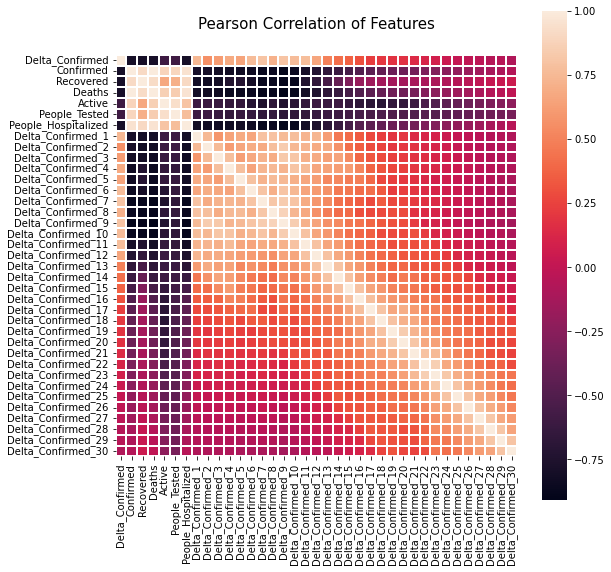

In [18]:
feature_list = ['Delta_Confirmed','Confirmed', 'Recovered', 'Deaths', 'Active','People_Tested', 'People_Hospitalized']
n=30
for i in range(n):
    feature_list.append('Delta_Confirmed_'+str(i+1))

plt.figure(figsize=(9,9))
plt.title('Pearson Correlation of Features',y=1.05,size=15)
sns.heatmap(train[feature_list].corr(),linewidths=0.1,vmax=1.0,square=True,linecolor='white')#,annot=True
plt.show();

As the correlation between Delta_Confirmed and history Delta_Confirmed data are very strong, we can probably start from using 'Delta_Confirmed_n' features. Try a simple linear regression and see what happens.

### 3.3.2 Some exploratory experiments
#### 1. Feasiblility test

Train a Linear Regression model using some of the 'Delta_Confirmed_n' data to predict 'Delta_Confirmed'.

In [19]:
func_txt = "Delta_Confirmed ~ Delta_Confirmed_1+Delta_Confirmed_2+Delta_Confirmed_3+Delta_Confirmed_4+Delta_Confirmed_5"
func_txt+="+Delta_Confirmed_6+Delta_Confirmed_7+Delta_Confirmed_8+Delta_Confirmed_9+Delta_Confirmed_10"
model = smf.ols(func_txt, data=train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Delta_Confirmed   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     40.97
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           7.08e-29
Time:                        12:03:49   Log-Likelihood:                -782.71
No. Observations:                  99   AIC:                             1587.
Df Residuals:                      88   BIC:                             1616.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            251.9224    106

Visualize the relation between y_predict and y_ground_truth of the training set. Calculate the RMSE on training set.

Training RMSE = 656.7020492037454


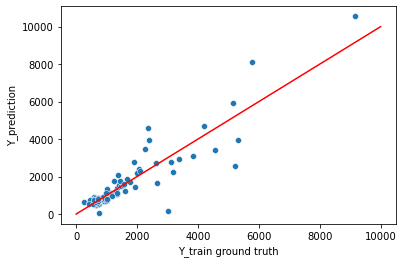

In [20]:
y_pred = results.predict(train)
y_gt = train['Delta_Confirmed']
sns.scatterplot(y = y_gt, x= y_pred)
plt.xlabel('Y_train ground truth')
plt.ylabel('Y_prediction')
print('Training RMSE = '+str(rmse(y_pred,y_gt)))
showRefLine()

Visualize the relation between y_predict and y_ground_truth of the validation set. Calculate the RMSE on validation set.

Test RMSE = 1438.7126465494932
Test R2 = -0.47227420438024015


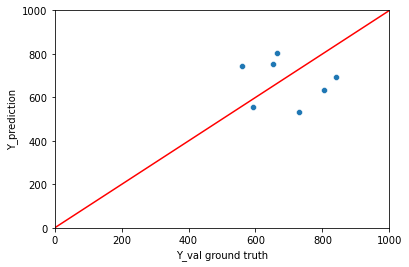

In [21]:
y_pred = results.predict(val)
y_gt = val['Delta_Confirmed']
sns.scatterplot(y = y_gt, x= y_pred)
plt.ylim(0, 1000)
plt.xlim(0, 1000)
plt.xlabel('Y_val ground truth')
plt.ylabel('Y_prediction')
print('Test RMSE = '+str(rmse(y_pred,y_gt)))
print('Test R2 = '+str(r2_score(y_gt,y_pred)))
showRefLine()

#### 2. How many history 'Delta_Confirmed' parameters should we use?

##### Do a K-fold cross validation on original_train set to find a best number for how many 'Delta_Confirmed_n' features to use in the model.

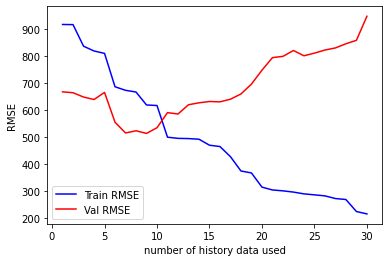

In [22]:
def cross_validation(dataset,cv,func_txt):
    idx = np.arange(len(dataset))
    # np.random.seed(71)
    np.random.shuffle(idx)
    test_size = len(dataset)/cv
    train_rmse = []
    test_rmse = []
    for i in range(cv):
        test_start_idx = (i-1)*test_size
        test_end_idx = i*test_size
        test_idx = np.arange(test_start_idx,test_end_idx)
        train_idx = np.concatenate((np.arange(test_start_idx),np.arange(test_end_idx,len(dataset))))
        train = dataset.iloc[train_idx]
        test = dataset.iloc[test_idx]
        model = smf.ols(func_txt, data=train)
        results = model.fit()
        y_train_pred = results.predict(train)
        y_train_gt = train['Delta_Confirmed']
        y_test_pred = results.predict(test)
        y_test_gt = test['Delta_Confirmed']
        train_rmse.append(rmse(y_train_pred,y_train_gt))
        test_rmse.append(rmse(y_test_pred,y_test_gt))
    return train_rmse,test_rmse
        
def visualize_perf_parameterNum(dataset,cv = 3,n_max=30):
    func_txt = "Delta_Confirmed ~ "
    trainRMSE_n = []
    testRMSE_n = []
    for i in range(n_max):
        func_txt+='+Delta_Confirmed_'+str(i+1)
        train_rmse_cv,test_rmse_cv = cross_validation(dataset,cv,func_txt)
        trainRMSE_n.append(np.mean(train_rmse_cv))
        testRMSE_n.append(np.mean(test_rmse_cv))
    # plt.figure(figsize=(9,9))
    num_history_data = np.arange(n_max)+1
    plt.plot(num_history_data,trainRMSE_n,'b',label='Train RMSE')
    plt.plot(num_history_data,testRMSE_n,'r',label='Val RMSE')
    plt.legend()
    plt.xlabel('number of history data used')
    plt.ylabel('RMSE')
    return trainRMSE_n,testRMSE_n

        

dataset = all_state_reports_delta[all_state_reports_delta['Province_State']=='New York'].drop(['Province_State'],axis=1)
cv = 5
n_max = 30
# train_rmse,test_rmse = cross_validation(dataset,cv,func_txt)
# print(np.mean(train_rmse))
# print(np.mean(test_rmse))
trainRMSE_n,testRMSE_n = visualize_perf_parameterNum(original_train ,cv,n_max)

Calculate the overall RMSE on original_train data and pick the parameters that has the lowest overall RMSE.

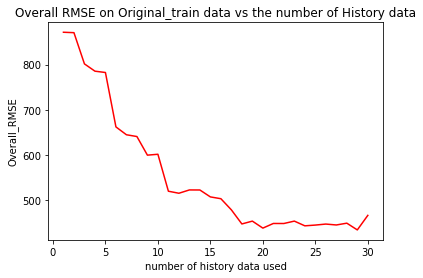

In [23]:
num_history_data = np.arange(n_max)+1
len_set = len(original_train)
sum_rmse = []
for i in range(len(testRMSE_n)):
    tmp = (testRMSE_n[i]**2)*len_set/cv+(trainRMSE_n[i]**2)*len_set*(cv-1)/cv
    tmp = np.sqrt(tmp/len_set)
    sum_rmse.append(tmp)
plt.xlabel('number of history data used')
plt.ylabel('Overall_RMSE')
plt.title('Overall RMSE on Original_train data vs the number of History data')
plt.plot(num_history_data,sum_rmse,'r');

As is illustrated, when the number of ‘Delta_Confirmed_n’ features reached 20, the overall RMSE loss reached the lowest stage. So, I'll use the ‘Delta_Confirmed’ of the past 20 days to predict a day’s ‘Delta_Confirmed’

## 3.4 Training, Cross Validation and Visualization

### 3.4.1 Use the past 20 day's delta Confirmed data Only

Use the past 20 day's Delta_Confirmed of each day as input, train the linear regressor on the whole original_train data to predict the Delta_Confirmed of that day.

In [24]:
func_txt = "Delta_Confirmed ~ Delta_Confirmed_1+Delta_Confirmed_2+Delta_Confirmed_3+Delta_Confirmed_4+Delta_Confirmed_5+Delta_Confirmed_6+Delta_Confirmed_7+Delta_Confirmed_8+Delta_Confirmed_9+Delta_Confirmed_10"
func_txt +="+Delta_Confirmed_11+Delta_Confirmed_12+Delta_Confirmed_13+Delta_Confirmed_14+Delta_Confirmed_15"
func_txt +="+Delta_Confirmed_16+Delta_Confirmed_17+Delta_Confirmed_18+Delta_Confirmed_19+Delta_Confirmed_20"

model = smf.ols(func_txt, data=original_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Delta_Confirmed   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     70.74
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           6.57e-46
Time:                        12:04:01   Log-Likelihood:                -807.18
No. Observations:                 110   AIC:                             1656.
Df Residuals:                      89   BIC:                             1713.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            605.8682     76

plot out the prediction and ground truth on original_train and test sets.

Training RMSE = 372.07136076738936


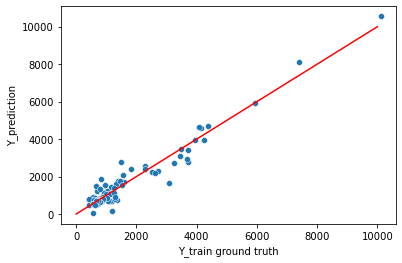

In [25]:
y_pred = results.predict(original_train)
y_gt = original_train['Delta_Confirmed']
sns.scatterplot(y = y_gt, x= y_pred)
plt.xlabel('Y_train ground truth')
plt.ylabel('Y_prediction')
print('Training RMSE = '+str(rmse(y_pred,y_gt)))
showRefLine()

Test RMSE = 113.4554125628844
Test R2 = -0.2999602981270464


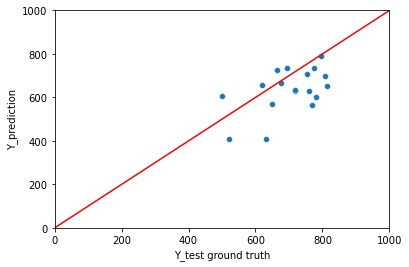

In [26]:
y_pred = results.predict(test)
y_gt = test['Delta_Confirmed']
sns.scatterplot(y = y_gt, x= y_pred)
plt.ylim(0, 1000)
plt.xlim(0, 1000)
plt.xlabel('Y_test ground truth')
plt.ylabel('Y_prediction')
print('Test RMSE = '+str(rmse(y_pred,y_gt)))
print('Test R2 = '+str(r2_score(y_gt,y_pred)))
showRefLine()

#### Make predictions on Test set.

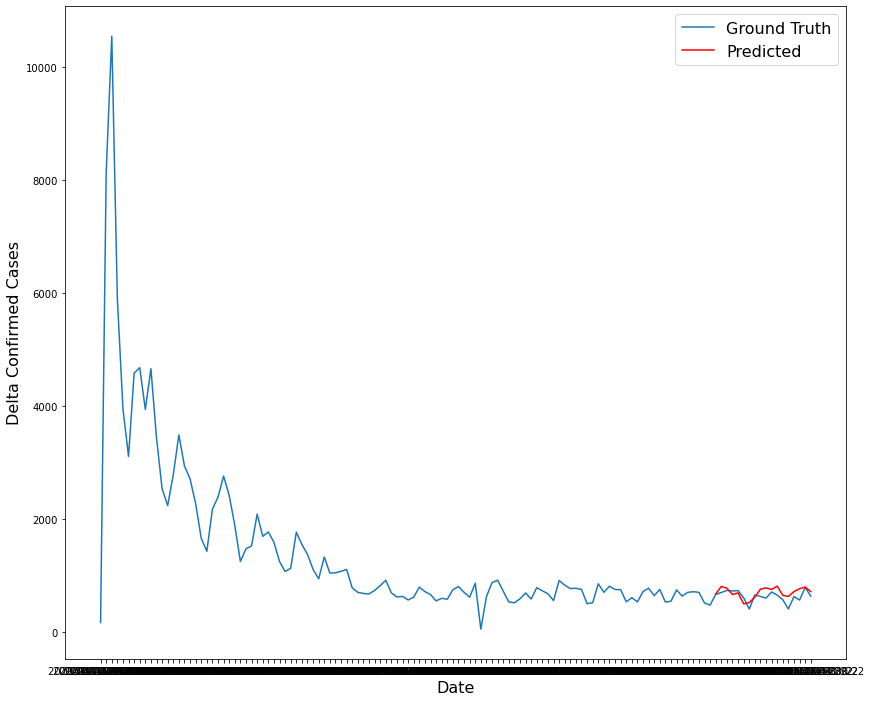

In [27]:
y_pred = results.predict(test)
plt.figure(figsize=(14,12))
plt.plot(dataset['Last_Update'],dataset['Delta_Confirmed'],label='Ground Truth')
plt.plot(test['Last_Update'],y_pred,'r',label='Predicted');
plt.legend()
plt.xlabel('Date',fontsize=16)
plt.ylabel('Delta Confirmed Cases',fontsize=16)
plt.legend(fontsize=16);

We can see that the prediction is slightly off from the ground truth. But most of the errors are within 10% of the ground truth value, which is enough for government or hospitals to make short-term decision or preparations based on the prediction of the next days number of delta confirmed cases.

#### Can I predict more days? 

However, just predicting the next day's situation may not be enough for government to make a useful plan for the next week or next month. So, here, I'll use the model trained above to make prediction on the test set without using the ground truth data in test set. That is to say, I can only use the ground truth data in original_train as history data. The Delta_Confirmed_1 of day t in test set will be the prediction of Delta_Confirmed of day (t-1).

Note that the first line in the following cell is different from that of the previous part.

Test R2 = -0.011020692086779027


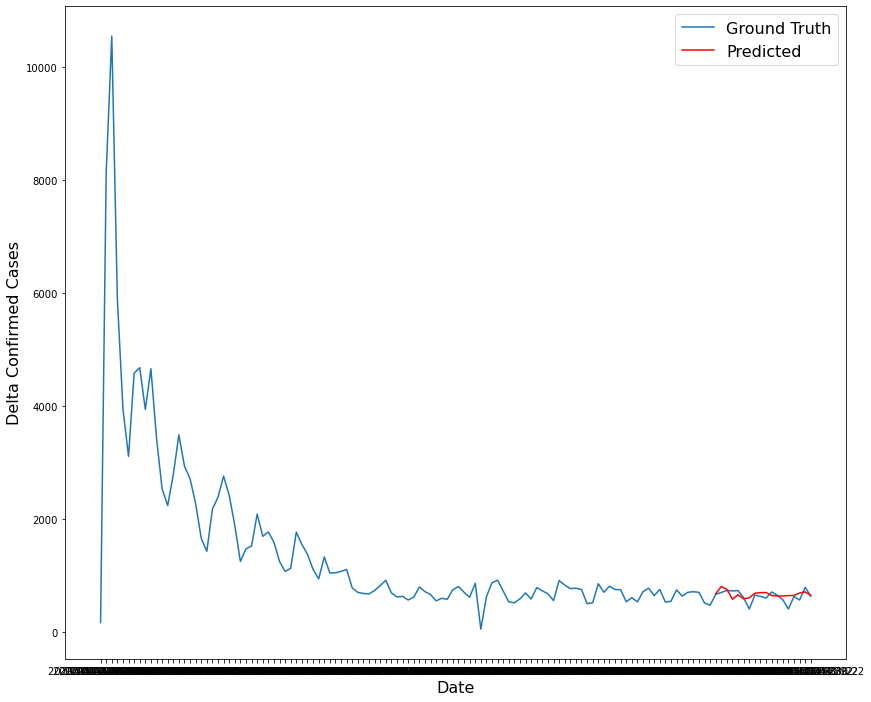

In [28]:
y_pred = predict_testset(results,test)
plt.figure(figsize=(14,12))
plt.plot(dataset['Last_Update'],dataset['Delta_Confirmed'],label='Ground Truth')
plt.plot(test['Last_Update'],y_pred,'r',label='Predicted');
plt.legend()
plt.xlabel('Date',fontsize=16)
plt.ylabel('Delta Confirmed Cases',fontsize=16)
plt.legend(fontsize=16);
print('Test R2 = '+str(r2_score(y_gt,y_pred)))

Although the prediction is not 100% accurate, it matches the pattern very good. That is to say, this model should be enough for the government to make a longer-term plan based on the history data.

### 3.4.2 Using more indicator features?

Use more features to predict a day's Delta_Confirmed and see what happens.

In [29]:
func_txt = "Delta_Confirmed ~ Confirmed+Delta_Confirmed_1+Delta_Confirmed_2+Delta_Confirmed_3+Delta_Confirmed_4+Delta_Confirmed_5+Delta_Confirmed_6+Delta_Confirmed_7+Delta_Confirmed_8+Delta_Confirmed_9+Delta_Confirmed_10"
func_txt +="+Delta_Confirmed_11+Delta_Confirmed_12+Delta_Confirmed_13+Delta_Confirmed_14+Delta_Confirmed_15"
func_txt +="+Delta_Confirmed_16+Delta_Confirmed_17+Delta_Confirmed_18+Delta_Confirmed_19+Delta_Confirmed_20"
model = smf.ols(func_txt, data=original_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Delta_Confirmed   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     67.48
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           3.30e-45
Time:                        12:04:07   Log-Likelihood:                -806.51
No. Observations:                 110   AIC:                             1657.
Df Residuals:                      88   BIC:                             1716.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2236.1105   1567

Test RMSE = 96.06921002691611
Test R2 = 0.06793094591333326


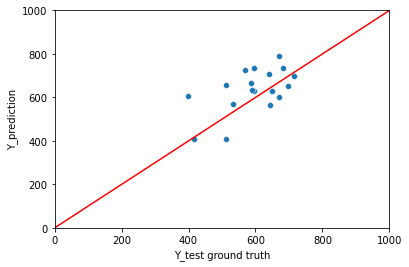

In [30]:
y_pred = results.predict(test)
y_gt = test['Delta_Confirmed']
sns.scatterplot(y = y_gt, x= y_pred)
plt.ylim(0, 1000)
plt.xlim(0, 1000)
plt.xlabel('Y_test ground truth')
plt.ylabel('Y_prediction')
print('Test RMSE = '+str(rmse(y_pred,y_gt)))
print('Test R2 = '+str(r2_score(y_gt,y_pred)))
showRefLine()

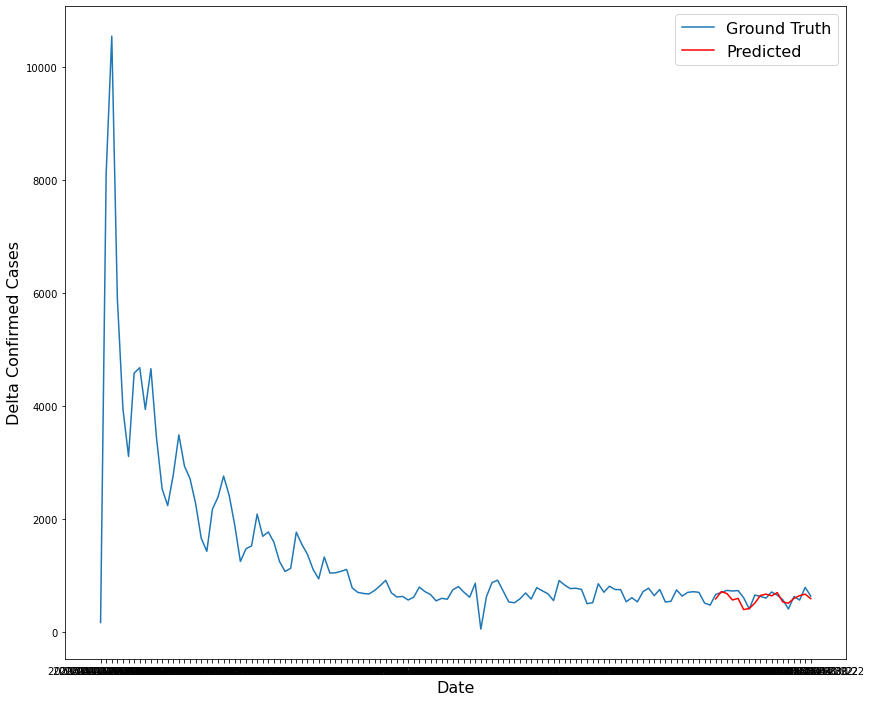

In [31]:
y_pred = results.predict(test)
plt.figure(figsize=(14,12))
plt.plot(dataset['Last_Update'],dataset['Delta_Confirmed'],label='Ground Truth')
plt.plot(test['Last_Update'],y_pred,'r',label='Predicted');
plt.legend()
plt.xlabel('Date',fontsize=16)
plt.ylabel('Delta Confirmed Cases',fontsize=16)
plt.legend(fontsize=16);

This prediction is much better than the previous one. So adding 'Confirmed' will help improve the performance of future number of confirmed cases. This is very reasonable I think. 

## 3.5 What about other models? More powerful model, like Random Forest?
I used Random Forest Regressor in this part to predict a day's 'Delta_Confirmed'

### 3.5.1 Use history data Only

In [39]:
from sklearn.ensemble import RandomForestRegressor
feature_list = []
n=20
for i in range(n):
        feature_list.append('Delta_Confirmed_'+str(i+1))
        
dataset = all_state_reports_delta[all_state_reports_delta['Province_State']=='New York'].drop(['Province_State'],axis=1)
train, val = train_test_split(dataset, test_size = 0.1, random_state = 127)
X_train = train[feature_list]
y_train = train['Delta_Confirmed']
X_val = val[feature_list]
y_val = val['Delta_Confirmed']
regr = RandomForestRegressor(max_depth=5, random_state=31,n_estimators=100)
regr.fit(X_train, y_train)
# print('Trainset R^2'+' = '+str(regr.score(X_train, y_train)),end=',   ')
# print('Trainset RMSE'+' = '+str(rmse(regr.predict(X_train), y_train)))
print('Testset R^2'+' = '+str(regr.score(X_val, y_val)),end=',   ')
print('Testset RMSE'+' = '+str(rmse(regr.predict(X_val), y_val)))


Testset R^2 = 0.9744243817542217,   Testset RMSE = 120.62148547393666


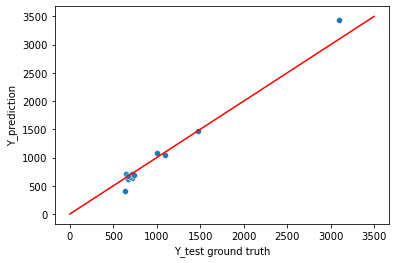

In [41]:
y_pred = regr.predict(X_val)
sns.scatterplot(y = y_val, x= y_pred)
plt.xlabel('Y_test ground truth')
plt.ylabel('Y_prediction')
showRefLine(3500)

### 3.5.2 What about adding more features?

In [42]:
feature_list = ['Confirmed', 'Recovered', 'Deaths', 'Active','People_Tested', 'People_Hospitalized']

n=20
for i in range(n):
        feature_list.append('Delta_Confirmed_'+str(i+1))
        
dataset = all_state_reports_delta[all_state_reports_delta['Province_State']=='New York'].drop(['Province_State'],axis=1)
train, val = train_test_split(dataset, test_size = 0.1, random_state = 127)
X_train = train[feature_list]
y_train = train['Delta_Confirmed']
X_val = val[feature_list]
y_val = val['Delta_Confirmed']
regr = RandomForestRegressor(max_depth=5, random_state=31,n_estimators=100)
regr.fit(X_train, y_train)
# print('Trainset R^2'+' = '+str(regr.score(X_train, y_train)),end=',   ')
# print('Trainset RMSE'+' = '+str(rmse(regr.predict(X_train), y_train)))
print('Testset R^2'+' = '+str(regr.score(X_val, y_val)),end=',   ')
print('Testset RMSE'+' = '+str(rmse(regr.predict(X_val), y_val)))

Testset R^2 = 0.983179029759188,   Testset RMSE = 97.82213189142894


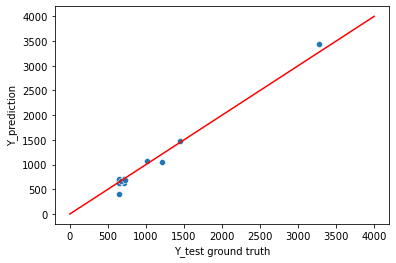

In [43]:
y_pred = regr.predict(X_val)
sns.scatterplot(y = y_val, x= y_pred)
plt.xlabel('Y_test ground truth')
plt.ylabel('Y_prediction')
showRefLine(4000)

_We can see that Random Forest Regressor does a good job at regression. Although the RMSE is no smaller than Linear Regression, but the R^2 is much higher than that of Linear Regression. So we may replace Linear Regression Model with Random Forest Regression Model in order to get a more reliable result in future works._

What's more, there are a buntch of powerful tools which are not taught in our lecture like Neural Networks, SVM, XGBoost......So probably in the future work, I can use these methods to get a more accurate prediction._